In [1]:
import numpy as np
import pandas as pd

# Load in the csv data
headlines_df = pd.read_csv("../data/headlines/labeled_headlines.csv", index_col=0, parse_dates=[0])

print("There are {} headlines".format(headlines_df.shape[0]))
headlines_df.head()

There are 3758 headlines


,postdate,source,headline,btc_label,ltc_label,eth_label
0,2017-01-01 13:50:25,coindesk.com,coindesk's charles bovaird asks the experts fo...,1,1,1
1,2017-01-01 15:33:53,coindesk.com,the blockchain industry is likely to see growt...,1,1,1
2,2017-01-01 21:04:02,coindesk.com,"the price of bitcoin passed 1,000 during the ...",1,1,1
3,2017-01-02 12:07:00,coindesk.com,do 2016's political changes foreshadow blockch...,1,0,1
4,2017-01-02 14:43:09,coindesk.com,bitspark's george harrap lists his takeaways f...,1,0,1


In [2]:
def print_distribution(df, labels_column_name, data_set_name):
    '''
    :param df: DataFrame with data to print
    :param labels_column_name: name of labels column in df
    :param data_set_name: Data set printing stats of
    :return: nothing
    '''
    n = df.shape[0]
    print("{} Set Distributions:\n".format(data_set_name))
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    print("\n")

###  2) Figure out some stuff about our data
    - What is the max number of words from all the headlines?
        - Need to know this for when we vectorize the words, we need to pad the vectors to all be the same length

In [3]:
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

max_words = get_max_words(headlines_df.headline.values)
print("Max number of words per headline: {}".format(max_words))

Max number of words per headline: 30


### 3) Split the data
    - What are the distributions of each data set?

In [4]:
# How many headlines to use for training -- Had to use 3006 to make sure to not split between a day
LABEL_COL = 'btc_label'
TEXT_COL = 'headline'
train_size = 3006

train_df = headlines_df[:train_size].copy()
test_df = headlines_df[train_size:].copy()

print('Splitting data...')
(x_train, y_train) = train_df[TEXT_COL].values, train_df[LABEL_COL]
(x_test, y_test) = test_df[TEXT_COL].values, test_df[LABEL_COL]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")
print_distribution(headlines_df, 'btc_label', 'Full')
print_distribution(train_df, 'btc_label', 'Train')
print_distribution(test_df, 'btc_label', 'Test')

Splitting data...
3006 train sequences
752 test sequences
----------------------------
Full Set Distributions:

btc_label labels frequency:
Value	Count	Percent
1	2231	59.366684406599255%
0	1527	40.633315593400745%


Train Set Distributions:

btc_label labels frequency:
Value	Count	Percent
1	1824	60.67864271457086%
0	1182	39.321357285429144%


Test Set Distributions:

btc_label labels frequency:
Value	Count	Percent
1	407	54.12234042553191%
0	345	45.87765957446808%




### 3) Build the initial model

In [5]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Input


######### Hyperparameters
max_features = 20000 # Controls the number of words in our vocabulary 
maxlen = max_words  # cut texts after this number of words (among top max_features most common words)
batch_size = 32  # mini-batch size
epochs = 6    


Using TensorFlow backend.


#### Pre-process the data by using Keras Tokenizer 
    - similar to the sklearn CountVectorizer we used before, but more powerful
    - https://keras.io/preprocessing/text/

In [6]:
# First train our Tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Second vectorize each headline
# Might want to train a different tokenizer on the test set?
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# For an RNN, ou need a 'sequence' of data as the input
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (3006, 30)
x_test shape: (752, 30)


### Build and train an RNN LSTM model with an Embedding layer input using the Keras Sequential API
 - Input = Embedding layer of size 128 (means it uses 128 features) Need to tune this probably
 - Hidden Layer = LSTM with 128 hidden units
 - Output = Sigmoid 
 - See: https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

In [7]:
# Functional API version of the same model
# The functional API is much more useful than the sequential API in terms of adaptability 
input_layer = Input(shape=(maxlen,), dtype='int32', name='main_input')

embedding_layer = Embedding(output_dim=128, input_dim=max_features, input_length=maxlen)(input_layer)

lstm_layer = LSTM(128)(embedding_layer)

output = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=input_layer, 
              outputs=output)
model.summary()

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, 
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 128)           2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________
Train on 3006 samples, validate on 752 samples
Epoch 1/6
3006/3006 [==============================] - 20s - loss: 0.6749 - acc: 0.6061 - val_loss: 0.6907 - val_acc: 0.5412
Epoch 2/6
3006/3006 [==============================] - 18s - loss: 0.5911 - acc: 0.6830 - va

### Evaluate the model

Some helper functions for evaluation

In [12]:
import matplotlib.pyplot as plt


####################
# Function to calculate the price changes based on coin data
####################
def calc_percent_change(price_list, num_days_back):
    # calculates in ascending order
    NUM_DAYS = len(price_list)

    # Create a numpy column vector to store price changes
    day_changes = np.zeros((NUM_DAYS, 1))

    # Calculate percent change
    for day in range(NUM_DAYS):
        if day < NUM_DAYS - num_days_back:
            day_changes[day + num_days_back] = ((price_list[day + num_days_back] - price_list[day]) \
                                           / float(price_list[day])) * 100
    return day_changes

####################
# Function to plot changes
####################
def plot_predicted_changes(changes, coin_name, media_name):
        colors = ['xkcd:crimson', 'xkcd:darkgreen']
        pred_colors = []
        percent_changes = []
        for change in changes:
            price_change, pred = change
            if price_change > 0:
                if pred == 1:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:  # incorrect
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])
            else:
                if pred == -1:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])

        plt.style.use('bmh')
        plt.figure(figsize=(14, 6))
        plt.title('{} - {}'.format(coin_name, media_name))
        plt.bar(range(len(percent_changes)), percent_changes, color=pred_colors)
        plt.ylabel('Percent Change', size=18)
        plt.xlabel('Days', size=18)
        plt.show()
        
def get_increase_decrease(df, sum_pred_labels_column, change_column, num_days_change, counts_per_day_column):
    '''
    df: (DataFrame) that contains the counts of labels per day and price change
    sum_pred_labels_column: (string) Column of predicted labels corresponding to unit of change used
    change_column: (string) The name of the column containing the amount of change
    num_days_of_change: (int) The number of days in the past change was calculated for
    counts_per_day_column: (string) The name of the column that has the counts of tweets/headlines per day
    '''
    # Note: This algorithm assumes that the labels were changed from 1/0 to 1/-1 after prediction so that when summed
    #       we get a value that represents the total number of both positive and negative labels
    # This algorithm will go through each row of the values zipped together and do the following:
    #      If sum of predicted labels > count_of_tweets_per_day/2
    #             If value in change_column + num_days_of_change > 0
    #                    append to list of price increase
    #       elif decrease do the opposite

    # 1) Extract the necessary columns as numpy arrays
    counts = df[counts_per_day_column].values
    sum_pred_labels = df[sum_pred_labels_column].values
    changes = df[change_column].values
    num_total_days = df.shape[0]

    # 2) perform algorithm
    cache = {}
    cache['price_increase'] = []
    cache['price_decrease'] = []
    cache['price_increase_wrong'] = []
    cache['price_decrease_wrong'] = []
    cache['all_price_increase'] = []
    cache['all_price_decrease'] = []
    all_changes = []

    for day in range(num_total_days - num_days_change):
        price_change = changes[day + num_days_change]
        # if the sum of predicted labels is the majority and the actual price increased, add to list
        if price_change > 0:
            if sum_pred_labels[day] > float(counts[day]) / 2.:
                cache['price_increase'].append(price_change)
                cache['all_price_increase'].append((price_change, 1))
                all_changes.append((price_change, 1))
            else:
                cache['price_increase_wrong'].append(price_change)
                cache['all_price_increase'].append((price_change, 0))
                all_changes.append((price_change, 2))


        # if the sum of predicted labels is not the majority and the actual price decreased
        elif price_change < 0:
            if sum_pred_labels[day] < abs(float(counts[day]) / 2.):
                cache['price_decrease'].append(price_change)
                cache['all_price_decrease'].append((price_change, 1))
                all_changes.append((price_change, -1))
            else:
                cache['price_decrease_wrong'].append(price_change)
                cache['all_price_decrease'].append((price_change, 0))
                all_changes.append((price_change, -2))

    return cache, all_changes

### Make predictions on the test set

In [13]:
pred_data_1day = model.predict(x_test)
pred_data_1day = (pred_data_1day > 0.5).astype(int)

In [16]:
# Read in the price data to use for analysis

COIN = 'BTC'
TEXT_COLUMN = 'headline'
TRAIN_START_DATE = '2017-01-01'
TEST_START_DATE = '2017-12-09'
TEST_END_DATE = '2018-2-10'

LABELS_COLUMN = '{}_label'.format(COIN.lower())
PREDICTED_LABELS_COLUMN = '{}_pred'.format(COIN.lower())

coin_df = pd.read_csv('../data/price_data/BTC_percent_change.csv', index_col=['Date'], parse_dates=True)
coin_df.head()

,Close,Volume,1D Percent Change
Date,,,
2017-01-01,1017.05,64951.63,0.000000
2017-01-02,1033.30,54788.01,1.597758
2017-01-03,1135.41,156272.17,9.881932
2017-01-04,989.35,240007.84,-12.864076
2017-01-05,886.16,194290.96,-10.430080


### Aggregate the data so we can compare the percent changes to the prediction results

In [17]:
# Make a copy of the dev or test df to use going forward
pred_df = test_df.copy()

######### Need to get rid of the time in the datetime format to get the rest of the code to work
pred_df['postdate'] = pd.DatetimeIndex(pred_df.postdate).normalize()
pred_df = pred_df.set_index('postdate')


# Add in the predicted labels to the dataframe
pred_df[PREDICTED_LABELS_COLUMN] = pred_data_1day

# Replace the 0's with -1's so when we sum() it will be easy
pred_df = pred_df.replace(0, -1)
# Access only the dates of the BitCoin Dev Set and sum all the labels
# This essentially gets rid of all the repeat dates, and gives a sum of total labels
# for eah date

# Need to drop the news text and source data so we can sum over the labels
pred_df = pred_df.drop(TEXT_COLUMN, axis=1)
pred_df = pred_df.drop('source', axis=1)


#print(pred_df.head())
pred_df = pred_df.groupby('postdate').agg(np.sum)
#pred_df = pred_df.loc[TEST_START_DATE:TEST_END_DATE].groupby(['postdate']).transform(sum)

#print(pred_df.head())
#print(pred_df_grouped.agg(np.sum))



DAYS_CHANGE = 1
# Need this secondary DataFrame to get counts
counts_df = pd.DataFrame(pred_df.groupby(['postdate']).size(), columns=['counts'])

# Cleanup the DataFrame
pred_df = pred_df.drop_duplicates()


# Last, merge all the stuff we just created into one DataFrame
pred_df = pd.concat([pred_df, coin_df, counts_df], axis=1, join_axes=[pred_df.index])

# Print out a small subset of the DataFrame
if (False):
    print(pred_df.head())
    print(pred_df.shape)


### Get analysis results and make a plot of the percent change and correct predictions
For plot:
 - red = did not predict correctly
 - green = predicted correctly

--------------------------------
Stats for 1 Day Positive Labels:
count    21.000000
mean      4.533051
std       3.544611
min       0.154784
25%       2.100288
50%       3.201581
75%       5.353030
max      11.690979
dtype: float64
--------------------------------
Stats for 1 Day Negative Labels:
count    6.000000
mean    -1.028299
std      1.029792
min     -2.675891
25%     -1.461441
50%     -0.968030
75%     -0.159027
max     -0.042573
dtype: float64
--------------------------------
Stats for 1 Day Positive Change Negative Labels:
count     5.000000
mean      6.062427
std       5.360987
min       0.114847
25%       0.404179
50%       8.797506
75%       9.887275
max      11.108330
dtype: float64
--------------------------------
Stats for 1 Day Negative Change Positive Labels:
count    23.000000
mean     -6.503632
std       4.384367
min     -17.235134
25%      -9.841073
50%      -5.498040
75%      -3.158855
max      -0.641292
dtype: float64
--------------------------------
count    56

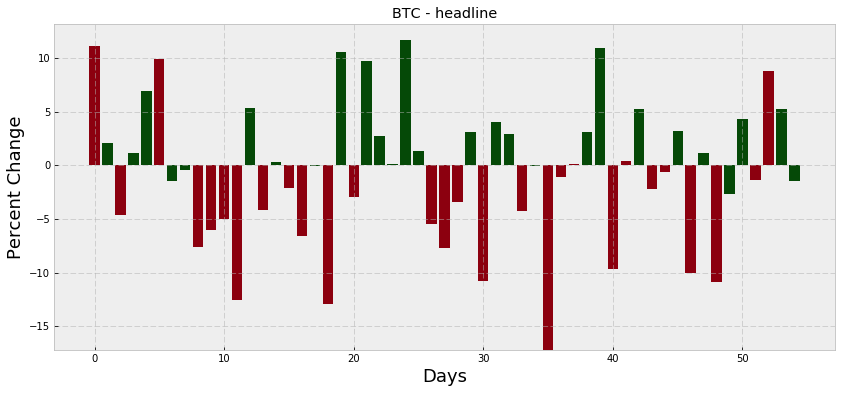

In [18]:
## Finally, perform the new evaluation and print out stats
cache, changes = get_increase_decrease(pred_df,
                                       PREDICTED_LABELS_COLUMN,
                                       '1D Percent Change',
                                       DAYS_CHANGE,
                                       'counts')

print("--------------------------------")
print("Stats for 1 Day Positive Labels:")
price_increase_1day_df = pd.Series(cache['price_increase'])
print(price_increase_1day_df.describe())

print("--------------------------------")
print("Stats for 1 Day Negative Labels:")
price_decrease_1day_df = pd.Series(cache['price_decrease'])
print(price_decrease_1day_df.describe())


print("--------------------------------")
print("Stats for 1 Day Positive Change Negative Labels:")
price_increase_1day_wrong_df = pd.Series(cache['price_increase_wrong'])
print(price_increase_1day_wrong_df.describe())

print("--------------------------------")
print("Stats for 1 Day Negative Change Positive Labels:")
price_decrease_1day_wrong_df = pd.Series(cache['price_decrease_wrong'])
print(price_decrease_1day_wrong_df.describe())

 # print stats for the full DataFrame to see how we compare to the average increases/decreases and max/mins
print("--------------------------------")
print(pred_df['1D Percent Change'].describe())


# Plot the changes
plot_predicted_changes(changes, COIN, TEXT_COLUMN)

### Look at some headlines we predicted incorrectly

In [19]:
i = 0
for actual, predicted in zip(test_df['btc_label'].values, pred_data_1day):
    if actual != predicted:
        print("----------------------")
        print("({}), real label={}, predicted label={}".format(test_df.iloc[i]['headline'], actual, predicted[0]))
    if i == 20:
        break
    i += 1

----------------------
(one of the most talked about technologies in development for bitcoin is the lightning network  but what does it do, and when might it be ready?), real label=1, predicted label=0
----------------------
(the cboe's website became unavailable just as it launched its first bitcoin futures contracts on sunday ), real label=1, predicted label=0
----------------------
(a presentation by the bank's wealth management execs declared that blockchain technology has a lot of potential, but was lukewarm of cryptocurrencies ), real label=1, predicted label=0
----------------------
(parity technologies has just released a proposal for reclaiming the millions in ether frozen last month due to a fault in its code ), real label=1, predicted label=0
----------------------
(public filings suggest that the launch of bitcoin futures products has renewed a push to create exchange traded funds tied to the cryptocurrency ), real label=1, predicted label=0
----------------------
(cboe's c

### Look at some headlines we predicted correctly

In [20]:
i = 0
for actual, predicted in zip(test_df['btc_label'].values, pred_data_1day):
    if actual == predicted:
        print("----------------------")
        print("({}), real label={}, predicted label={}".format(test_df.iloc[i]['headline'], actual, predicted[0]))
    if i == 20:
        break
    i += 1

----------------------
(utility token icos are not equity, but sellers may still be giving up more value than they realize if they go down that path ), real label=1, predicted label=1
----------------------
(days before a major futures product launch, bitcoin suffered heavy losses saturday, a trend that so far appears to be continuing into sunday ), real label=1, predicted label=1
----------------------
(forks offer ideological leaders the chance to put their ideas on improving protocols into practice without getting bogged down in endless bickering ), real label=1, predicted label=1
----------------------
(cboe may use information gleaned from futures trading to make a case to the securities and exchange commission to allow bitcoin linked etf ), real label=1, predicted label=1
----------------------
(lawmakers in gibraltar approved a piece of legislation last week that fits into the government's broader plans for blockchain ), real label=1, predicted label=1
----------------------
(th